In [42]:
# Import the libraries
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from sklearn.datasets import fetch_kddcup99
import pickle
import os
import seaborn as sns
# from pyspark.sql import SparkSession
from pprint import pprint
import logging
import warnings

In [2]:
# Setup the spark warnings
warnings.filterwarnings("ignore") 
logging.getLogger('py4j').setLevel(logging.ERROR) 
logging.getLogger('pyspark').setLevel(logging.ERROR) 
log4j_conf_path = "file:///home/quivigorelli/Distributed-K-Means-Clustering/spark/DistributedKmeans/log4j.properties"

In [3]:
# Functions
def labelToInt(label):
    '''
    Map from set of labels in original dataset (`strings`) into set of natural numbers (`int`) for easier manipulation of rdd
    '''
    uniqueLabels=list(np.unique(y))
    return uniqueLabels.index(label)


def deleteBytes(datum):
    '''
    Clean dataset from categorical attributes, leaving numerical ones
    Arguments:
    One datum of the rdd.
    Return:
    Updated datum.
    '''
    x = datum[1]["x"]
    mask = [type(i) != bytes for i in x]
    datum[1]["x"] = np.asarray(x[mask])
    print(x)
    print(mask)
    return datum


def localPlusPlusInit(points, k): 
    '''
    KMeans++ initialization.
    Arguments:
    `points`: array (n, dim) of points to be clustered;
    `k`: desired number of centroids. 
    Returns:
    Initial array (k, dim) of centroids, k<=n.
    '''
    # Sample one point uniformly from points array
    C=points[np.random.choice(points.shape[0])]
    C=C[np.newaxis, :]
    
    for _ in range(k):
        # Compute array (n,1) of probabilities associated to each point
        probs=np.min(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1).flatten()
        # Normalize probability distribution
        probs=probs/np.sum(probs)
        
        # Draw one new centroid according to distrbution
        nextCentroid=points[np.random.choice(points.shape[0], p=probs)][np.newaxis,:]
        # Add centroid to array
        C=np.vstack((C, nextCentroid))
    return C


def weightedAverage(group):
    """
    Compute weighted average of a group from a pd.DataFrame with point coordinates, weights, clusterId.
    Utilized in local (non-distributed) version of Lloyds algorithm, needed also in K-Means//
    """
    weight_column='weights'
    groupby_column='clusterId'
    columns_to_average = group.columns.difference([weight_column, groupby_column])
    weighted_averages = group[columns_to_average].multiply(group[weight_column], axis=0).sum() / group[weight_column].sum()
    return weighted_averages


def localLloyds(points, k, C_init=None, weights=None, n_iterations=100, logDict=None):
    """
    Local (non-distributed) Lloyds algorithm
    Arguments:
    `points`: array (n, dim) of points to cluster;
    `k`: number of desired clusters;
    `C_init`: optional, array (k, dim) of initial centroids
    `weights`: optional, weights for weighted average in centroid re-computing;
    `n_iterations`: optional, number of iteration in lloyds algorithm;
    `logDict`: optional, dictionary {'CostsKmeans', 'tIterations', 'tTotal'} to store cost and time info.
    Return:
    Array of expected centroids.
    """
    t0 = time()

    # Storing cost and time info
    my_kMeansCosts = []
    tIterations = []
    
    df=pd.DataFrame(points)

    # If weights not given, assume uniform weights for points
    if weights is None:
        weights=np.ones(shape=len(points))
    df['weights']=weights
    df['clusterId']=np.zeros(shape=len(points))

    # If no C_init, default to K-Means++ initialization
    if C_init is None:
        C=localPlusPlusInit(points, k)
    else:
        C=C_init
   
    clusterId=np.argmin(np.sum((points[:,:,np.newaxis]-C.T[np.newaxis,:,:])**2, axis=1), axis=1)
    for iteration in range(n_iterations):
        t1=time()

        # Compute centroid given cluster
        df['clusterId']=clusterId
        C_df=df.groupby('clusterId')\
            .apply(weightedAverage)\
            .reset_index()

        # Compute cluster given centroid
        C_array=C_df[C_df.columns.difference(['weights', 'clusterId'])].reset_index(drop=True).to_numpy()
        squared_distances=np.sum((points[:,:,np.newaxis]-C_array.T[np.newaxis,:,:])**2, axis=1)
        clusterId=np.argmin(squared_distances, axis=1)
        my_cost=sum(squared_distances[np.arange(len(squared_distances)), clusterId])

        my_kMeansCosts.append(my_cost)
        t2 = time()
        
        tIteration = t2 - t1
        tIterations.append(tIteration)

    tEnd = time()
    tTotal = tEnd - t0

    # Store cost and time info
    if logDict is not None:
        logDict["CostsKmeans"] = my_kMeansCosts
        logDict["tIterations"] = tIterations
        logDict["tTotal"] = tTotal
    
    return C_array 


def minmaxRescale(datum, minS, maxS):
    """
    Rescale datum in [0,1] interval for better clusterization
    Arguments:
    `datum`: see rdd format;
    `minS`: array of min coordinate value among points for each attribute;
    `maxS`: as `minS` with max.
    Return:
    Updated datum.
    """
    mask = np.array(minS < maxS).astype(bool)
    feature = datum[1]["x"] 
    feature = (feature[mask] - minS[mask])/(maxS[mask] - minS[mask])
    return (datum[0], {"x": feature, "y": datum[1]["y"], "d2":datum[1]["d2"]}) 


def selectCluster(datum, C, updateDistances=True):
    """
    Associate datum to its centroid and optionally updates squared distance between them.
    Arguments:
    `datum`: see rdd format;
    `C`: array (k, len(datum[1]["x"]));
    `updateDistances`: if True, updates `datum[1]["d2"]` with squared distance between datum point and closest centroid in C.
    Return:
    Updated datum.
    """
    distances = np.sum((datum[1]["x"] - C)**2, axis=1)
    print('distances: ',distances)
    clusterId = np.argmin(distances)
    if updateDistances is True:
        return (clusterId, {'x':datum[1]['x'], 'y':datum[1]['y'], 'd2':distances[clusterId]})
    else:
        return (clusterId, datum[1])


def updateCentroids(Rdd):
    """
    Update centroids as spatial average of cluster points
    Argument:
    `Rdd`: see rdd format;
    Return:
    Updated array of centroids.
    """
    C=Rdd.mapValues(lambda xy: (xy['x'], 1))\
              .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
              .mapValues(lambda a:a[0]/a[1])\
              .values()\
              .collect() 
    C=np.array(C) #check later more carefully if causes some overhead
    return C


def updateDistances(Rdd, C):
    """
    Update Rdd with square distances from centroids, given Rdd with clusters already assigned to each point
    Arguments:
    `Rdd`: see rdd format;
    `C`: array of cluster centroids.
    Return:
    Updated rdd.
    """
    def datumUpdate(datum, C):
        '''
        Update a datum of the rdd with distance from assigned centroid
        '''
        d2=np.sum((datum[1]['x']-C[datum[0]])**2)
        #return datum
        return (datum[0], {"x": datum[1]["x"], "y": datum[1]["y"], "d2":d2})
    Rdd=Rdd.map(lambda datum:datumUpdate(datum, C))
    return Rdd


def cost(Rdd):
    """
    Calculate global cost of clusterization, from an Rdd with distances from centroids already updated
    """
    my_cost=Rdd.map(lambda datum : datum[1]['d2'])\
               .reduce(lambda a,b: a+b)
    return my_cost 


def kMeans(Rdd, C_init, maxIterations, logParallelKmeans=None):
    """
    Distributed (parallel) Lloyds algorithm
    Arguments:
    `Rdd`: see rdd format;
    `C_init`: array (k, dim) of initial centroids;
    `maxIterations`: max number of iterations;
    `logParallelKmeans`: optional, dictionary {'CostsKmeans', 'tIterations', 'tTotal'} to store cost and time info.
    Return:
    Array of expected centroids.
    """
    
    t0 = time()

    # Storing cost and time info
    my_kMeansCosts = []
    tIterations = []
    C=C_init

    for t in range(maxIterations):
        t1 = time()
        RddCached = Rdd.map(lambda datum: selectCluster(datum, C)).persist() ###
        
        # Now we compute the new centroids by calculating the averages of points belonging to the same cluster.
        C=updateCentroids(RddCached)
        my_cost = cost(RddCached)
        
        my_kMeansCosts.append(my_cost)
        t2 = time()
        
        tIteration = t2 - t1
        tIterations.append(tIteration)
        
        #RddCached.unpersist() 

        # Break loop if convergence of cost is reached
        if (len(my_kMeansCosts) > 1) and (my_kMeansCosts[-1] > 0.999*my_kMeansCosts[-2]):
            break

    tEnd = time()
    tTotal = tEnd - t0

    # Store cost and time info in argument dictionary
    if logParallelKmeans is not None:
        logParallelKmeans["CostsKmeans"] = my_kMeansCosts
        logParallelKmeans["tIterations"] = tIterations
        logParallelKmeans["tTotal"] = tTotal

    return C


def naiveInitFromSet(Rdd, k, spark_seed=12345,logNaiveInit=None):
    """
    Uniform sampling of k points from Rdd
    Arguments:
    `Rdd`: see rdd structure;
    `k`: desired number of clusters;
    `spark_seed`: optional, seed for spark random sampling;
    `logNaiveInit`: optional, dictionary {'tTotal'} to store time info.
    Return:
    Initial array (k, dim) of centroids.
    """
    t0 = time()
    # Sampling. Replacement is set to False to avoid coinciding centroids BUT no guarantees that in the original dataset all points are distinct!!!
    kSubset=Rdd.takeSample(False, k, seed=spark_seed)
    C_init=np.array([datum[1]['x'] for datum in kSubset])

    tEnd = time()
    
    if logNaiveInit is not None:
        logNaiveInit["tTotal"] = tEnd - t0
        
    return C_init


def naiveInitFromSpace(k, dim):
    """
    Uniform drawing of k points from euclidean space assuming the Rdd has been mapped into a [0,1]^dim space
    Arguments:
    `k`: desired number of clusters;
    `dim`: dimensionality of points space.
    Return:
    Initial array (k, dim) of centroids.
    """
    C_init=np.random.uniform(size=(k,dim))
    return C_init


def parallelInit(Rdd, k, l, logParallelInit=None):
    """
    Parallel initialization
    Arguments:
    `Rdd`: see rdd structure;
    `k`: desired number of clusters;
    `l`: coefficient to adjust sampling probability in order to obtain at least k centroids;
    `logParallelInit`: optional, dictionary {'CostsKmeans', 'tIterations', 'tTotal'} to store cost and time info.
    Return:
    Initial array (k, dim) of centroids.
    """
    t0 = time()
    
    # initialize C as a point in the dataset
    C=naiveInitFromSet(Rdd, 1) 
    
    # associate each datum to the only centroid (computed before) and computed distances and cost
    Rdd=Rdd.map(lambda datum : (0, datum[1]))
    Rdd=updateDistances(Rdd, C).persist() ###
    
    my_cost=cost(Rdd)

    # number of iterations (log(cost))
    n_iterations=int(np.log(my_cost))
    if(n_iterations<1): n_iterations=1
    
    tSamples = []
    tCentroids = []
    CostInits = [my_cost]
    # iterative sampling of the centroids
    for _ in range(n_iterations):

        t1=time()
        # sample C' according to the probability
        C_prime=Rdd.filter(lambda datum : np.random.uniform()<l*datum[1]['d2']/my_cost)\
                   .map(lambda datum : datum[1]['x'])\
                   .collect()
        C_prime=np.array(C_prime)
        t2=time()

        # stack C and C', update distances, centroids, and cost
        if (C_prime.shape[0]>0):
            C=np.vstack((C, C_prime))
            
            #Rdd.unpersist() ###
            Rdd=Rdd.map(lambda datum: selectCluster(datum, C)).persist() ###
            
            my_cost=cost(Rdd)
        t3=time()

        tSample = t2 -t1
        tCentroid = t3 - t2
        tSamples.append(tSample)
        tCentroids.append(tCentroid)
        CostInits.append(my_cost)
       
    #erase centroids sampled more than once 
    C=C.astype(float)
    C=np.unique(C, axis=0)
    Rdd=Rdd.map(lambda datum: selectCluster(datum, C))
    
    #compute weights of centroids (sizes of each cluster) and put them in a list whose index is same centroid index as C
    wx=Rdd.countByKey()
    weights=np.zeros(len(C))
    weights[[list(wx.keys())]]=[list(wx.values())]
    
    #subselection of k centroids from C, using local Lloyds algorithm with k-means++ initialization
    if C.shape[0]<=k:
        C_init=C
    else:
        C_init=localLloyds(C, k, weights=weights, n_iterations=100) #can be set to lloydsMaxIterations for consistency TODO

    tEnd = time()
    
    if logParallelInit is not None:
        logParallelInit["tSamples"] = tSamples
        logParallelInit["tCentroids"] = tCentroids
        logParallelInit["CostInit"] = CostInits
        logParallelInit["tTotal"] = tEnd - t0

    #Rdd.unpersist() ###
    return C_init

def predictedCentroidsLabeler(C_expected, C_predicted):
    """
    Associate expected and predicted centroids based on distance.
    Parameters:
    `C_expected`: array (k, dim) of expected centroids;
    `C_predicted`: array (k,dim) of predicted centroids;
    Return:
    List of labels, one for each expected centroid and pointing to its nearest predicted centroid;
    List of corresponding distances.
    """
    # Compute the distance matrix
    distMatrix=np.sum((C_expected[:,:,np.newaxis]-C_predicted.T[np.newaxis, :,:])**2,axis=1)
    # The labeler i-th entry j, tells that i-th centroid of C_expected is associated to j-th element of C_predicted
    labeler=np.argmin(distMatrix,axis=1)
    # Square distance of element of C_expected to nearest point in C_predicted
    distances=np.sqrt(np.array(distMatrix[np.arange(len(distMatrix)),labeler]).astype(float))
    return labeler, distances


def nearestCentroidDistances(C):
    """
    Associate each centroid to the distance of the nearest one
    Parameters:
    `C`:  array (k, dim) of centroids;
    Return:
    List of labels, one for each centroid and pointing to its nearest centroid;
    List of corresponding distances.
    """
    # Compute the distance matrix
    distMatrix=np.sum((C[:,:,np.newaxis]-C.T[np.newaxis, :,:])**2,axis=1)
    distMatrix+=np.diag(np.repeat(np.inf, distMatrix.shape[0]))
    
    # The labeler i-th entry j, tells that i-th centroid of C_expected is associated to j-th element of C_predicted
    labeler=np.argmin(distMatrix,axis=1)
    
    # Square distance of element of C_expected to nearest point in C_predicted
    distances=np.sqrt(np.array(distMatrix[np.arange(distMatrix.shape[0]),labeler]).astype(float))
    return labeler, distances

# Spark setup

In [4]:
# Build a spark session
spark = SparkSession.builder \
    .master("spark://spark-master:7077")\
    .appName("ResultsApplication")\
    .config("spark.executor.memory", "512m")\
    .getOrCreate()

# Create a spark context and set the logLevel
sc = spark.sparkContext
sc.setLogLevel("ERROR")

24/07/08 18:51:54 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


We are running applications on a Spark cluster consisting of one master node and two worker nodes (slaves). Each worker node is equipped with 4 CPU cores and 6.8 GB of memory. The master node manages the cluster resources and job scheduling, while the worker nodes execute the tasks assigned by the master, enabling efficient distributed data processing.

# Data exploration

The *KDD Cup 1999* is a widely dataset used for evaluating network intrusion detection systems. It contains simulated network traffic data, with each instance representing a connection and labeled as either normal or one of various types of network attacks. The full dataset includes 41 features capturing different characteristics of the network connections. 

For more information, visit the [official website](https://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html).

In [5]:
# Fetch the data
data = fetch_kddcup99(return_X_y = True)


In this scenario, we loaded the entire dataset into memory to parallelize it later, which is not always feasible due to memory constraints. A more general approach would be to parallelize the dataset directly from the file using Spark. However, we chose to repeat certain operations both on the parallelized dataset and locally to observe and compare the differences in terms of time efficiency. 

In [6]:
print("The number of records is ", data[0].shape[0])
print("The dimensionality of each record is ", data[0].shape[1])

The number of records is  494021
The dimensionality of each record is  41


In [7]:
# Divide samples (attributes) and features (targets)
x = data[0]
y = data[1] 

In [8]:
# Optionally, shuffle the dataset
shuffling=True

if shuffling:
    shuffled_indices = np.random.permutation(len(y))
    x=x[shuffled_indices]
    y=y[shuffled_indices]

In [9]:
# Optionally, subselect the dataset (suggested to shuffle first)
subLen = 300_000
x = x[:subLen,]
y = y[:subLen]

In [10]:
# Parallallelize the dataset
nSlice = None # number of partition (if None, returns the total number of cores of the workers)
Rdd = sc.parallelize([(None, {"x": x[i],"y": y[i], "d2":None}) for i in range(len(y))], numSlices = nSlice)

We parallelized the dataset using a custom data structure where each record is represented as a tuple with two elements. The first element is an integer (defaulting to None) that references the index of the centroids array. The second element is a dictionary containing three keys: the attribute (an array of $41$ entries), the target, and the squared distance from the selected centroid.

In [11]:
# Check the number of partitions
print("The number of partions used is: ", Rdd.getNumPartitions())

The number of partions used is:  8


In the following, we explore the dataset to understand the attributes types and the number of unique elements for each feature. 

In [12]:
# Attribute names from the official documentation
attributes = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate"
]

In [13]:
# Persist the Rdd used to work on each individual record (datum)
RddX = Rdd.map(lambda datum: datum[1]["x"]).persist()

# Collect the type of each attribute
typeElement = RddX.map(lambda x: [set([type(x[i])]) for i in range(len(x))])\
                  .reduce(lambda a, b: [a[i].union(b[i]) for i in range(len(a))])

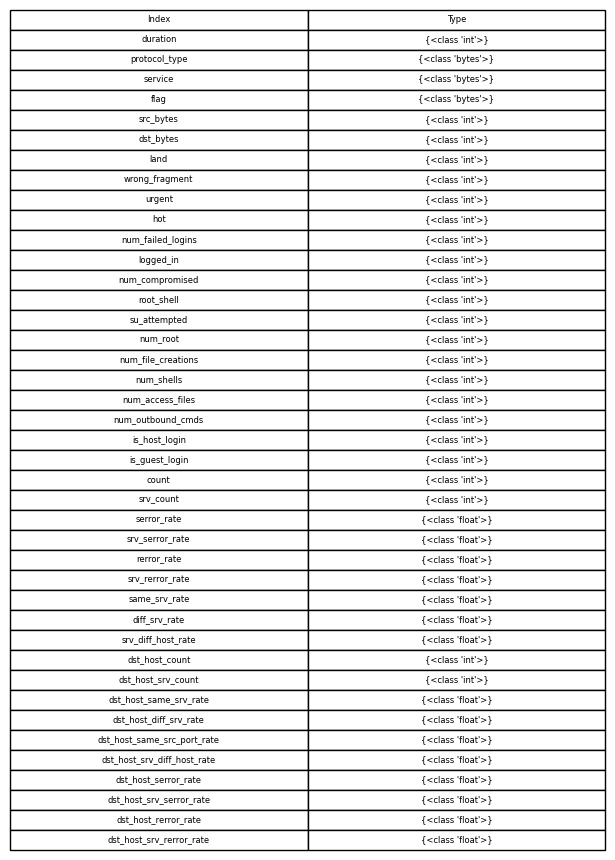

In [14]:
# Convert the types into strings
types_str = [str(t) for t in typeElement]

# Show the results with matplotlib
fig, ax = plt.subplots()

# Hide the axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
table_data = [[attributes[i], types_str[i]] for i in range(len(types_str))]
column_labels = ("Index", "Type")
table = ax.table(cellText=table_data, colLabels=column_labels, cellLoc='center', loc='center')

# Adjust the table
table.auto_set_font_size(False)
table.set_fontsize(6)
table.scale(1.2, 1.2)


We examined the number of **unique values for each attribute dimension**. This helps us understand the diversity of inputs in the dataset and provides insight into the characteristics and significance of each feature.

We performed the task both in parallel and locally. Not surprisingly, executing it in parallel takes considerably longer than executing it locally. This is because the "count unique" query is not easily parallelizable and is more efficient when processed directly in the RAM of a single device, minimizing overhead. However, this approach assumes that the entire dataset can fit into the RAM of the device, which is not always feasible.

In [15]:
%%time
# Collect the number of unique entries for each dimension of the attributes
uniquesParallel = []
for i in range(41):
    # Map to select the i-th attribute, then count unique occurencies
    s = RddX.map(lambda x: x[i])\
        .distinct()\
        .count()
    uniquesParallel.append(s)

# Unpersist the RddX RDD
RddX.unpersist()

CPU times: user 224 ms, sys: 87.5 ms, total: 311 ms
Wall time: 32.7 s


PythonRDD[1] at RDD at PythonRDD.scala:53

In [16]:
print("The number of uniques for each dimension is", uniquesParallel)

The number of uniques for each dimension is [1691, 3, 65, 11, 2773, 8635, 2, 3, 2, 20, 5, 2, 14, 2, 3, 13, 12, 3, 5, 1, 1, 2, 456, 426, 89, 43, 73, 45, 96, 71, 62, 256, 256, 101, 101, 101, 65, 96, 57, 101, 101]


In [17]:
%%time
# Count unique occurencies locally with numpy
uniques = []
for i in range (x.shape[1]):
    k = (len(np.unique(x[:, i])))
    uniques.append(k)
    
print("The uniques are:", uniques)

The uniques are: [1691, 3, 65, 11, 2773, 8635, 2, 3, 2, 20, 5, 2, 14, 2, 3, 13, 12, 3, 5, 1, 1, 2, 456, 426, 89, 43, 73, 45, 96, 71, 62, 256, 256, 101, 101, 101, 65, 96, 57, 101, 101]
CPU times: user 7.16 s, sys: 11.2 ms, total: 7.18 s
Wall time: 7.19 s


Now we do the same for the **unique target values**

In [18]:
%%time
# Persist the RDD for the target values
RddY = Rdd.map(lambda datum: datum[1]["y"]).persist()

# Count the number of unique occurencies
kTrue = RddY.distinct()\
        .count()

CPU times: user 12.2 ms, sys: 0 ns, total: 12.2 ms
Wall time: 754 ms


The number of unique targets represents the **true value of $k$** in the KMeans algorithm. In practical applications, this value is typically unknown, but currently, our focus is on assessing data processing performance rather than iterating over possible $k$ values.

In [19]:
print("The true number of the classes is", kTrue)

The true number of the classes is 23


In [20]:
%%time
# Count the number of records for each target label
uniquesParallely = RddY.countByValue()

# Unpersist the target RDD
RddY.unpersist()

print("The y things are:", uniquesParallely)

The y things are: defaultdict(<class 'int'>, {b'normal.': 59005, b'neptune.': 65065, b'smurf.': 170553, b'teardrop.': 596, b'satan.': 972, b'warezclient.': 622, b'back.': 1360, b'portsweep.': 619, b'ipsweep.': 801, b'pod.': 171, b'ftp_write.': 2, b'nmap.': 137, b'land.': 13, b'rootkit.': 5, b'imap.': 8, b'guess_passwd.': 27, b'loadmodule.': 7, b'buffer_overflow.': 18, b'warezmaster.': 10, b'multihop.': 5, b'phf.': 1, b'spy.': 1, b'perl.': 2})
CPU times: user 4.05 ms, sys: 0 ns, total: 4.05 ms
Wall time: 377 ms


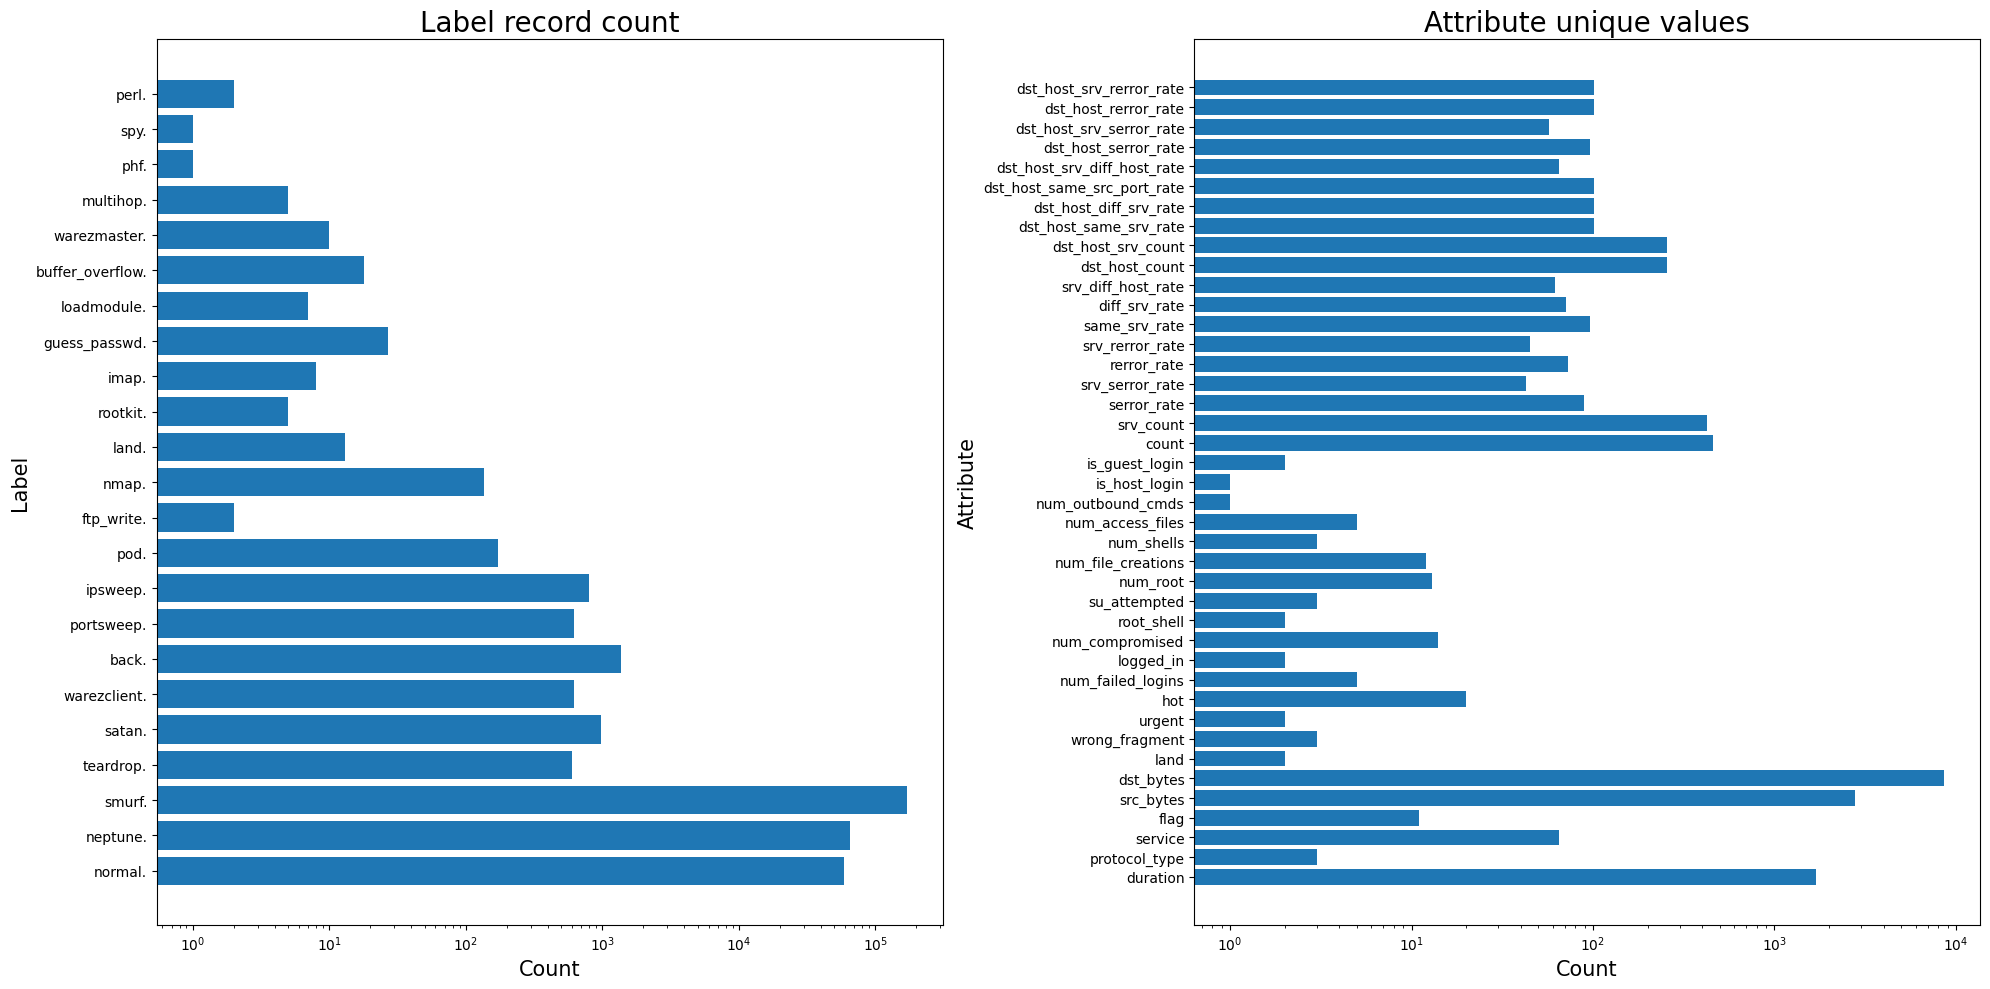

In [21]:
# Plot the occurrencies
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
title_fontsize = 20
label_fontsize = 15

# Labels
yUnique = [a.decode('utf-8') for a in uniquesParallely.keys()]
xUnique = list(uniquesParallely.values())
ax[0].barh(yUnique, xUnique)
ax[0].set_xlabel("Count", fontsize=label_fontsize)
ax[0].set_ylabel("Label", fontsize=label_fontsize)
ax[0].set_xscale("log")
ax[0].set_title("Label record count", fontsize=title_fontsize)

# Attributes
ax[1].barh(attributes, uniquesParallel)
ax[1].set_xlabel("Count", fontsize=label_fontsize)
ax[1].set_ylabel("Attribute", fontsize=label_fontsize)
ax[1].set_xscale("log")
ax[1].set_title("Attribute unique values", fontsize=title_fontsize)

fig.tight_layout()

Now, we remove the categorical variables that we observed are linked to the Byte types. 
Afterward, we persist the RDD for future use.

In [22]:
# Remove the categorical attributes and persist
Rdd = Rdd.map(deleteBytes)\
         .persist()

In [23]:
# Print the dimensionality after the cut off
numberColumns = len([i for i in typeElement if i != set([bytes])])
print("The number of columns (dimensionality) after filtering the bytes is", numberColumns)

The number of columns (dimensionality) after filtering the bytes is 38


# Parallel data processing

Now, we execute a single run of the algorithm for additional one-shot analysis. The comprehensive benchmarking for the full analysis is conducted in another notebook, and the results will be presented in the next section of this report.

In [24]:
%%time
# Collect the maxiumum and minimum value for each dimension
maxS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.maximum(a, b))
minS = Rdd.map(lambda datum: datum[1]["x"])\
           .reduce(lambda a, b: np.minimum(a, b))

# Rescale each dimension in the [0, 1] interval
# Remove the attributes for which max = min
Rdd = Rdd.map(lambda datum: minmaxRescale(datum, minS, maxS))\
         .persist()

CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 6.82 s


In [25]:
%%time
# Define the log dictionary
logParallelInit = {}
logParallelKmeans = {}

# Define k and l for KMeans|| initialization
k=kTrue
l=k*2 

# KMeans|| initialization
C_init = parallelInit(Rdd, k, l, logParallelInit)
# Lloyd iterations on the resulting centroids
C = kMeans(Rdd, C_init, 15, logParallelKmeans)

CPU times: user 2.43 s, sys: 85.2 ms, total: 2.51 s
Wall time: 15min 30s


## KMeans performance

Now, we define a custom pipeline to evaluate the algorithm's performance. The test focuses on assessing the typical cluster distance using the true labels and comparing them with the predicted labels.

In [26]:
# Select again the clusters and persist the RDD
Rdd=Rdd.map(lambda datum: selectCluster(datum, C)).persist()
C_predicted=C # For clarity of notation

# Compute the predicted population of each cluster
predictedPopulationDict=Rdd.countByKey()
predictedPopulationDict = dict(sorted(predictedPopulationDict.items(), key=lambda item: item[1], reverse=True))

In [27]:
# RDD based on the true target values
expectedRdd=Rdd.map(lambda datum:(labelToInt(datum[1]['y']), datum[1])) # Use true values as ClusterID
C_expected=updateCentroids(expectedRdd) # Compute the expected centroids
expectedRdd=updateDistances(expectedRdd, C_expected) # Update the squared distance values

# Compute the expected population of each cluster
expectedPopulationDict=Rdd.map(lambda datum:(datum[1]['y'], datum[1])).countByKey()
expectedPopulationDict = dict(sorted(expectedPopulationDict.items(), key=lambda item: item[1], reverse=True))

As a sanity check, we compare the population of the expected and predicted clusters

Text(0, 0.5, 'Population')

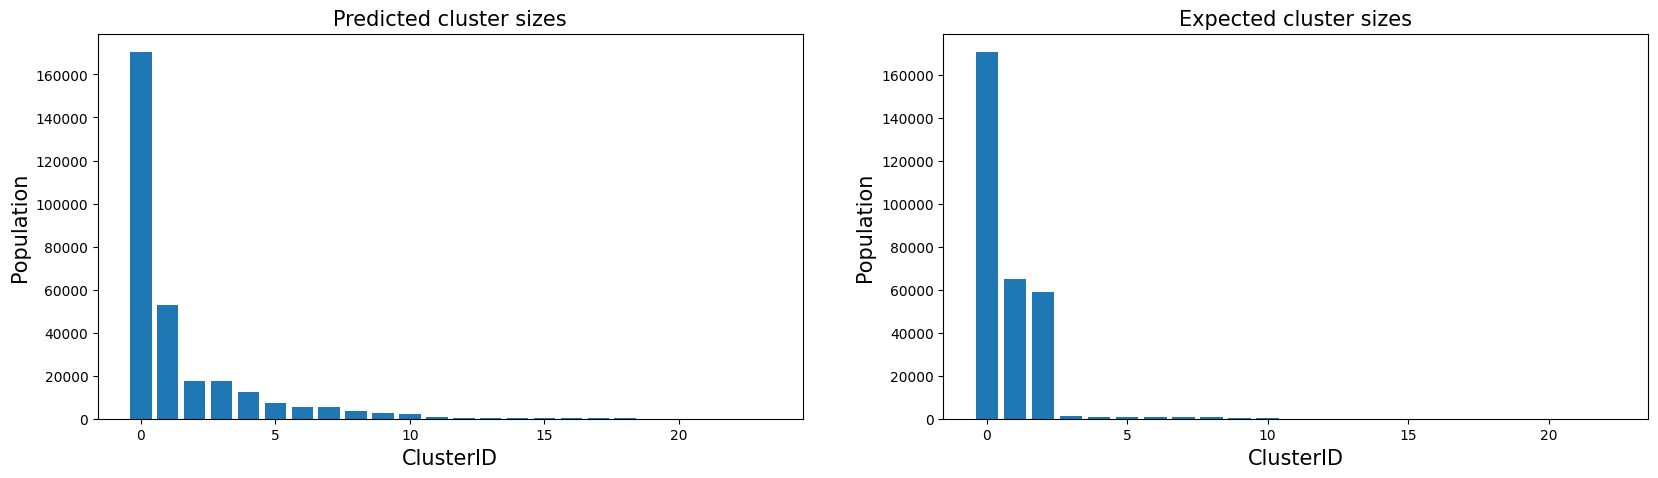

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
label_fontsize = 15
title_fontsize = 20
ax[0].bar(np.arange(len(predictedPopulationDict)), predictedPopulationDict.values())
ax[0].set_title("Predicted cluster sizes", fontsize=label_fontsize)
ax[0].set_xlabel("ClusterID", fontsize=label_fontsize)
ax[0].set_ylabel("Population", fontsize=label_fontsize)

ax[1].bar(np.arange(len(expectedPopulationDict)), expectedPopulationDict.values())
ax[1].set_title("Expected cluster sizes", fontsize=label_fontsize)
ax[1].set_xlabel("ClusterID", fontsize=label_fontsize)
ax[1].set_ylabel("Population", fontsize=label_fontsize)

Next, we calculate the mean squared error between the expected centroids and their nearest predicted centroids after associating each expected centroid with the closest predicted one.

In [29]:
# Associate predicted and expected centroids
labeler, distancesPredictedExpected=predictedCentroidsLabeler(C_expected, C_predicted)
# Compute the MSE
meanSquaredError=np.sum(distancesPredictedExpected**2)/len(distancesPredictedExpected)

print('Index of nearest predicted centroid to each expected centroid:', labeler)
print('Distances between expected centroids and nearest predicted centroids:', distancesPredictedExpected)
print('MeanSquaredError: ', meanSquaredError)

Index of nearest predicted centroid to each expected centroid: [18 16 17 15  7 17 12  4 16 18  3  0  0 22 17 16  4 21 16 22 16  5 17]
Distances between expected centroids and nearest predicted centroids: [2.67140854e-01 7.04271191e-01 7.60096473e-01 5.35103343e-01
 4.22126474e-01 4.69552730e-01 8.26663976e-04 1.11451630e+00
 1.10092859e+00 5.52633364e-01 8.04691149e-01 9.50619689e-01
 1.09097151e+00 8.03570042e-01 1.22689293e+00 6.16942607e-01
 6.23929935e-01 1.34857048e+00 4.02928522e-01 1.12987874e+00
 1.05705078e+00 1.34747947e-01 6.41524997e-01]
MeanSquaredError:  0.654639967564056


In [30]:
# Compute the typical distance of each "true" cluster (standard deviation)
stdExpected=expectedRdd.mapValues(lambda datum1: (datum1['d2'], 1))\
                        .reduceByKey(lambda a,b : (a[0]+b[0], a[1]+b[1]))\
                        .mapValues(lambda a:np.sqrt(a[0]/a[1]))\
                        .collect()

stdExpected=list(zip(*stdExpected))

In the following plot we show:
- with blue errorbars the typical distance of each expected cluster with respect to the expected centroid
- with blue boxes the distances to each expected centroid of its nearest **expected** centroid (nearest neighbour)
- with red bars the distances to each expected centroid of its nearest **predicted** centroid (error with the respect to the optimal value)

Text(0, 0.5, 'Distance [a.u.]')

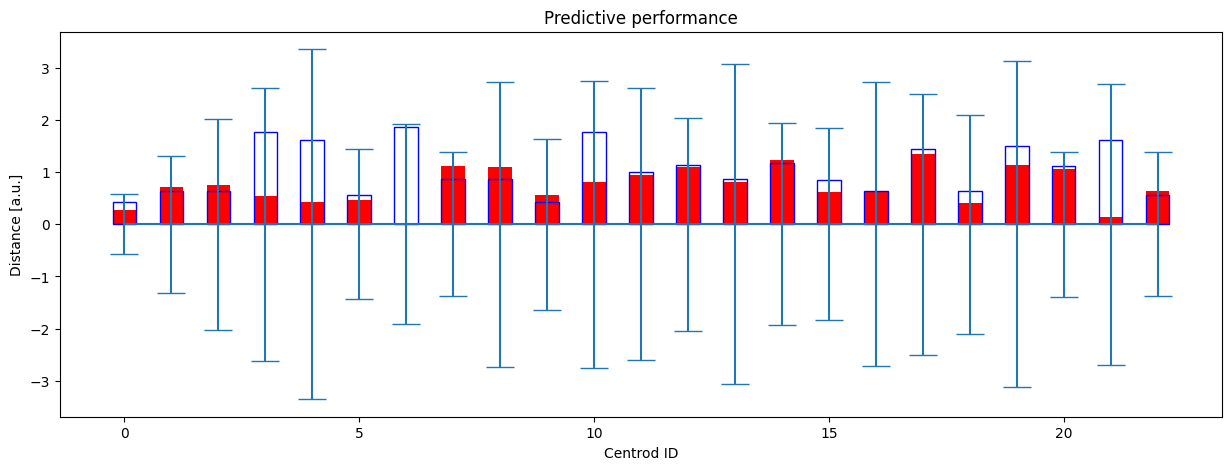

In [31]:
plt.figure(figsize=(15, 5))
xloc = np.arange(len(C_expected))
plt.errorbar(np.arange(len(C_expected)), np.zeros(shape=(len(stdExpected[0]))), stdExpected[1], capsize=10)
plt.bar(xloc, distancesPredictedExpected, width=0.5, color='red')
plt.bar(xloc, nearestCentroidDistances(C_expected)[1], width=0.5, edgecolor='blue', facecolor='none')

plt.title("Predictive performance")
plt.xlabel("Centrod ID")
plt.ylabel("Distance [a.u.]")

# Benchmarks

## Import the log files and description

At each run of the algorithm (pre-processing, initialization, and Lloyd iterations), we saved a log file with information about time efficiency and algorithm performance. Each file, saved as a pickle, contains a dictionary with data from a scan over a predefined set of workers to compare parallel performance. Each dictionary has a nested structure of "dictionaries of dictionaries" to handle different run contexts in a unified and flexible manner. This flexibility comes with the drawback of a more complex usage.

In [43]:
# Location of the log files
filesP = os.listdir("dataP")  # Parallel initialization
filesR = os.listdir("dataR")  # Naive (random) initialization

print("filesP has ", len(filesP), "files")
print("filesR has ", len(filesR), "files")

filesP has  2 files
filesR has  2 files


In [44]:
# Load the pickles with the logs in two lists (parallel and random)
totalLogP = []
for file in filesP:
    pathFile = os.path.join("dataP", file)
    with open(pathFile, 'rb') as f:
        s = pickle.load(f)
    totalLogP.append(s)

totalLogR = []
for file in filesR:
    pathFile = os.path.join("dataR", file)
    with open(pathFile, 'rb') as f:
        s = pickle.load(f)
    totalLogR.append(s)

Here examples of nested dictionary structures. The first one refers to a "Parallel Init" run, while the second one to a "Random Init" run.

In [45]:
# Parallel init example
pprint(totalLogP[0])

{'tDurationsParallel': {'Number of partition128': 1126.6152312755585,
                        'Number of partition16': 915.2583429813385,
                        'Number of partition2': 2916.459883928299,
                        'Number of partition256': 1316.1773827075958,
                        'Number of partition32': 1161.9603824615479,
                        'Number of partition4': 1718.7826912403107,
                        'Number of partition64': 972.8995172977448,
                        'Number of partition8': 876.2816195487976},
 'tPreOperationsParallel': {'Number of partition128': 19.820308446884155,
                            'Number of partition16': 10.725661039352417,
                            'Number of partition2': 18.64969515800476,
                            'Number of partition256': 29.06898808479309,
                            'Number of partition32': 13.518644094467163,
                            'Number of partition4': 12.929564952850342,
                

In [46]:
# Random init example
pprint(totalLogR[0])

{'tDurationsNaive': {'Number of partition128': 246.70958375930786,
                     'Number of partition16': 86.43284273147583,
                     'Number of partition2': 235.50393104553223,
                     'Number of partition256': 251.0647897720337,
                     'Number of partition32': 69.03074526786804,
                     'Number of partition4': 113.30451202392578,
                     'Number of partition64': 163.41193318367004,
                     'Number of partition8': 97.91845202445984},
 'tPreOperationsNaive': {'Number of partition128': 14.513504028320312,
                         'Number of partition16': 9.8938889503479,
                         'Number of partition2': 15.74240779876709,
                         'Number of partition256': 20.451018571853638,
                         'Number of partition32': 9.526236057281494,
                         'Number of partition4': 10.653437614440918,
                         'Number of partition64': 10.46751666

## Time efficiency

Now, we unpack the data to compare the mean total execution time. We group our data by multiple runs, the number of partitions, and the three steps of each run: pre-processing, initialization (either parallel or random), and Lloyd iterations. 

In [47]:
# Metadata about the run
int_partitions = [2, 4, 8, 16, 32, 64, 128, 256]
name_partitions = ["Number of partition" + str(i) for i in int_partitions]

# Unpack the data for the parallel
n_files = len(totalLogP) # Number of independent runs over all the partitions
n_partitions = len(name_partitions) # Number of partitions used for each run
tTotalP = np.zeros((n_files, n_partitions, 3)) # Numpy array to fill

for i in range(n_files):
    log = totalLogP[i]
    for p in range(n_partitions):
        partition = name_partitions[p]
        tTotalP[i, p, 0] = log["tPreOperationsParallel"][partition]
        tTotalP[i, p, 1] = log["totalLogParallelInit"][partition]["tTotal"]
        tTotalP[i, p, 2] = log["totalLogParallelKmeans"][partition]["tTotal"]

# Unpack the data for the naive
n_files = len(totalLogR)
tTotalR = np.zeros((n_files, n_partitions,3))

for i in range(n_files):
    log = totalLogR[i]
    for p in range(n_partitions):
        partition = name_partitions[p]
        tTotalR[i, p, 0] = log["tPreOperationsNaive"][partition]
        tTotalR[i, p, 1] = log["totalLogNaiveInit"][partition]["tTotal"]
        tTotalR[i, p, 2] = log["totalLogNaiveKmeans"][partition]["tTotal"]


In [48]:
# Compute the mean time and standard deviation of each steps (parallel init)
meansP = np.mean(tTotalP, axis=0)
stdDevsP = np.std(tTotalP, axis=0)

# Compute the mean time and standard deviation of each steps (random init)
meansN = np.mean(tTotalR, axis=0)
stdDevsN = np.std(tTotalR, axis=0)

Comparison of the total execution time for the full pipeline of the algorithm between parallel and naive initialization methods. We divided the total time into three stages to a more detailed comparison.

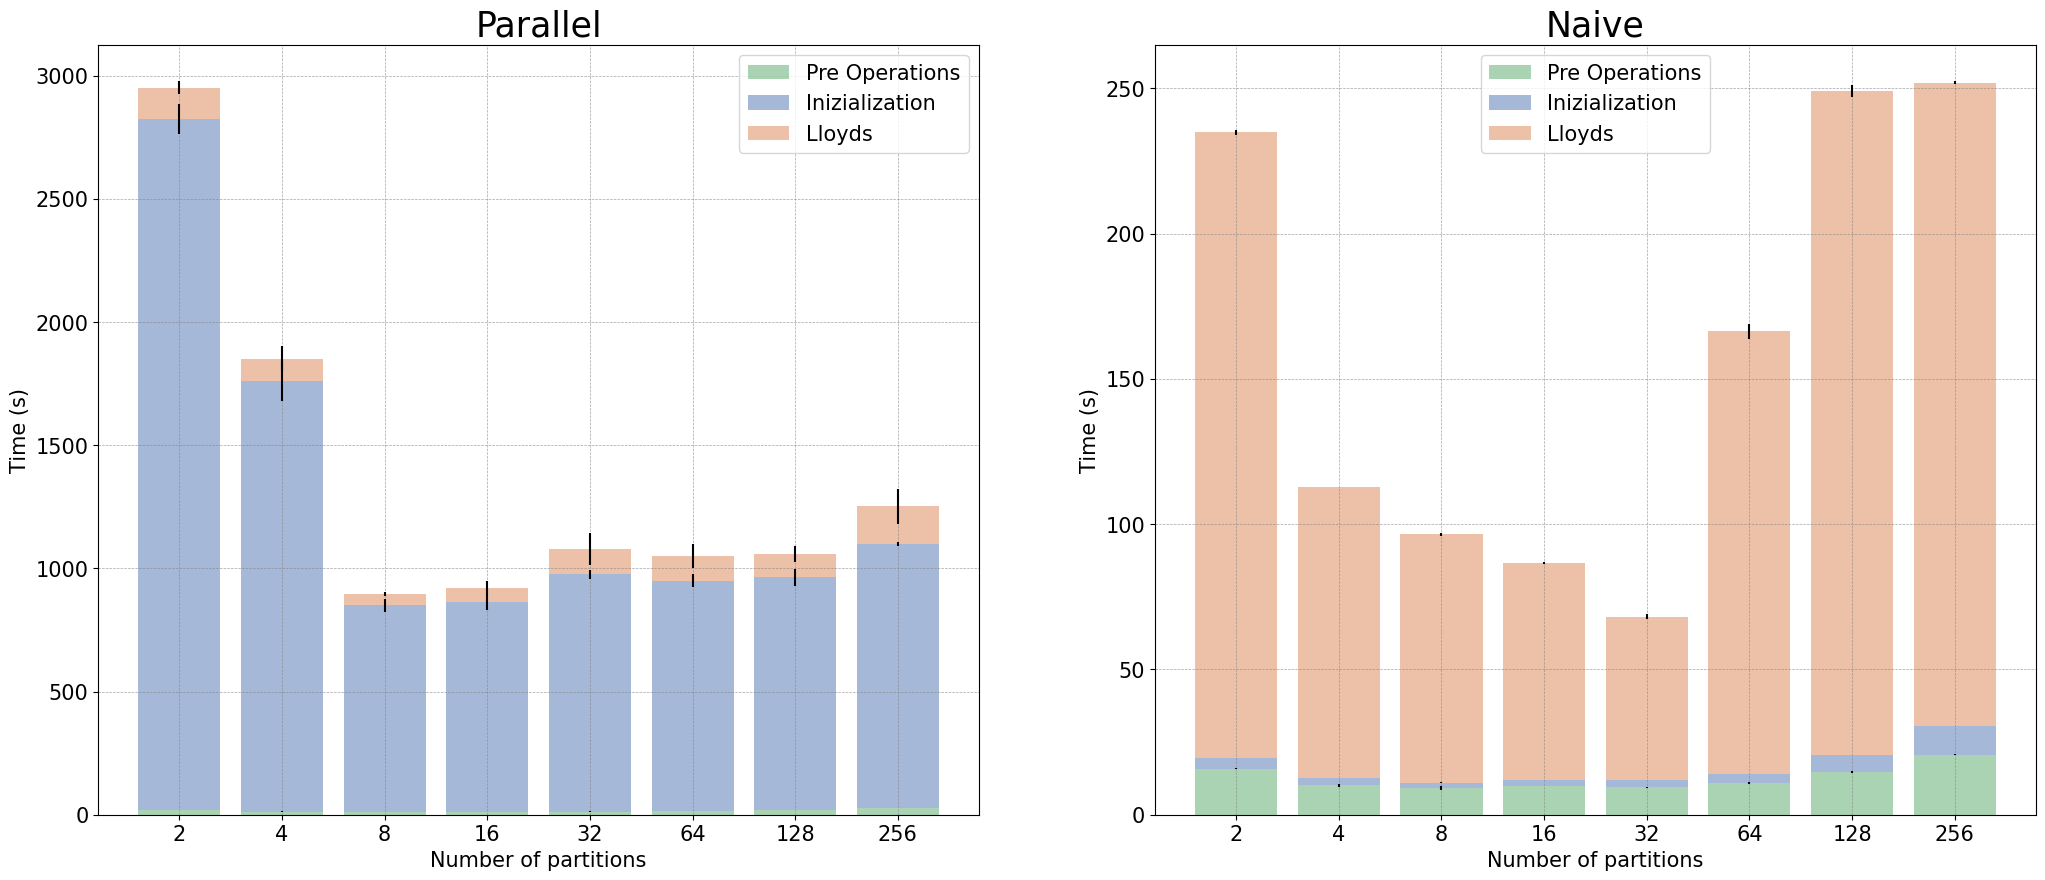

In [49]:
# Barplot of the stacked times for the parallel
fig, ax = plt.subplots(1, 2, figsize=(25, 10), sharey=False)
colors = sns.color_palette("deep", n_colors=3)
title_fontsize = 25
label_fontsize = 15

ax[0].bar(np.arange(n_partitions), meansP[:, 0], bottom = 0, yerr=stdDevsP[:, 0], alpha=0.5, label="Pre Operations", color=colors[2])
ax[0].bar(np.arange(n_partitions), meansP[:, 1], bottom = meansP[:, 0], yerr=stdDevsP[:, 1], alpha=0.5, label="Inizialization", color=colors[0])
ax[0].bar(np.arange(n_partitions), meansP[:, 2], bottom = (meansP[:, 0]+meansP[:, 1]), yerr=stdDevsP[:, 2], alpha=0.5, label="Lloyds", color=colors[1])
ax[0].set_xticks(np.arange(n_partitions))
ax[0].set_xticklabels(int_partitions)
ax[0].tick_params(axis='x', labelsize=label_fontsize)
ax[0].tick_params(axis='y', labelsize=label_fontsize)
ax[0].set_xlabel("Number of partitions", fontsize=label_fontsize)
ax[0].set_ylabel("Time (s)", fontsize=label_fontsize)
ax[0].set_title("Parallel", fontsize=title_fontsize)
ax[0].legend(fontsize=label_fontsize)
ax[0].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')  


ax[1].bar(np.arange(n_partitions), meansN[:, 0], bottom = 0, yerr=stdDevsN[:, 0], alpha=0.5, label="Pre Operations", color=colors[2])
ax[1].bar(np.arange(n_partitions), meansN[:, 1], bottom = meansN[:, 0], yerr=stdDevsN[:, 1], alpha=0.5, label="Inizialization", color=colors[0])
ax[1].bar(np.arange(n_partitions), meansN[:, 2], bottom = (meansN[:, 0]+meansN[:, 1]), yerr=stdDevsN[:, 2], alpha=0.5, label="Lloyds", color=colors[1])
ax[1].set_xticks(np.arange(n_partitions))
ax[1].set_xticklabels(int_partitions)
ax[1].tick_params(axis='x', labelsize=label_fontsize)
ax[1].tick_params(axis='y', labelsize=label_fontsize)
ax[1].set_xlabel("Number of partitions", fontsize=label_fontsize)
ax[1].set_ylabel("Time (s)", fontsize=label_fontsize)
ax[1].set_title("Naive", fontsize=title_fontsize)
ax[1].legend(fontsize=label_fontsize)
ax[1].grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')  


Each subplot of the above figure shows a bar plot of the algorithm's performance for the three steps, divided by the number of partitions used. Please note that the bars are stacked, so the total time taken to complete a run is represented by the total height of each bar.

Now we visually compare the time spent based on the number of iterations and partitions used for sampling and updating centroids, specifically focusing on parallel initialization.

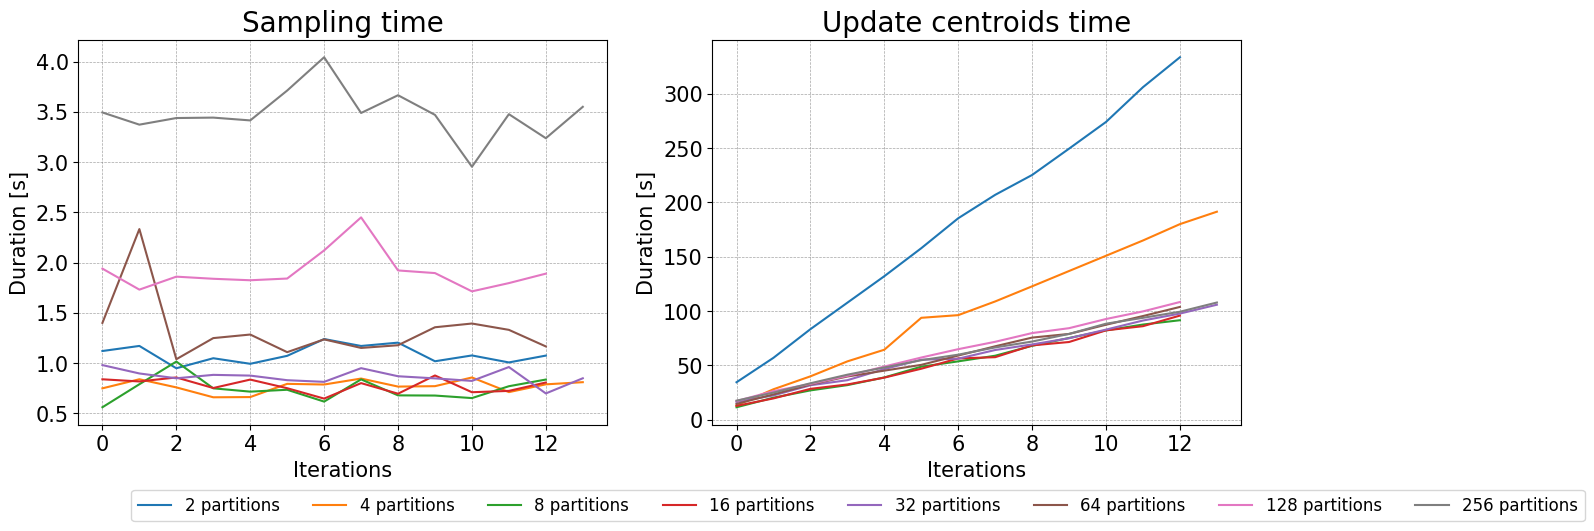

In [50]:
# Unpack tSamples and tCentroids for each number of partitions
PIDA_tSamples=parallelInitDataArray=[[sample['totalLogParallelInit'][n_partition]['tSamples'] for n_partition in name_partitions] for sample in totalLogP]
PIDA_tCentroids=parallelInitDataArray=[[sample['totalLogParallelInit'][n_partition]['tCentroids'] for n_partition in name_partitions] for sample in totalLogP]

# Choose a sample (independent runs of the algorithm for a given set of possible partitions)
sample=0

# Plot the results
label_names = [str(int_partitions[i])+" partitions" for i in range(len(int_partitions))]
title_fontsize = 20
label_fontsize = 15

fig, (ax0, ax1)=plt.subplots(ncols=2, nrows=1, figsize=(15, 5))
# tSamples
for i in range(len(name_partitions)):
    ax0.plot(PIDA_tSamples[sample][i], label=label_names[i])
ax0.set_xlabel('Iterations', fontsize=label_fontsize)
ax0.set_ylabel('Duration [s]', fontsize=label_fontsize)
ax0.set_title('Sampling time', fontsize=title_fontsize)
ax0.tick_params(axis='x', labelsize=label_fontsize)
ax0.tick_params(axis='y', labelsize=label_fontsize)
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')  

# tCentroids
for i in range(len(name_partitions)):
    ax1.plot(PIDA_tCentroids[sample][i], label=label_names[i])
ax1.set_xlabel('Iterations', fontsize=label_fontsize)
ax1.set_ylabel('Duration [s]', fontsize=label_fontsize)
ax1.set_title('Update centroids time', fontsize=title_fontsize)
ax1.tick_params(axis='x', labelsize=label_fontsize)
ax1.tick_params(axis='y', labelsize=label_fontsize)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax1.legend(loc=(-1.1, -0.25), fontsize=12, ncols=len(int_partitions))

## KMeans cost

We also analyze the dependency of the cost function on the number of iterations and partitions for parallel, Lloyd's, and naive initializations. The cost function is defined as sum of the squared distances between each points and the nearest centroid. In formula, 
$\text{Cost} = \sum_{x}\min_{i=1,...,k} ||{x-c_i}||^2$ where $c_i$ is an element of the set of centroids and $x$ a point in space.

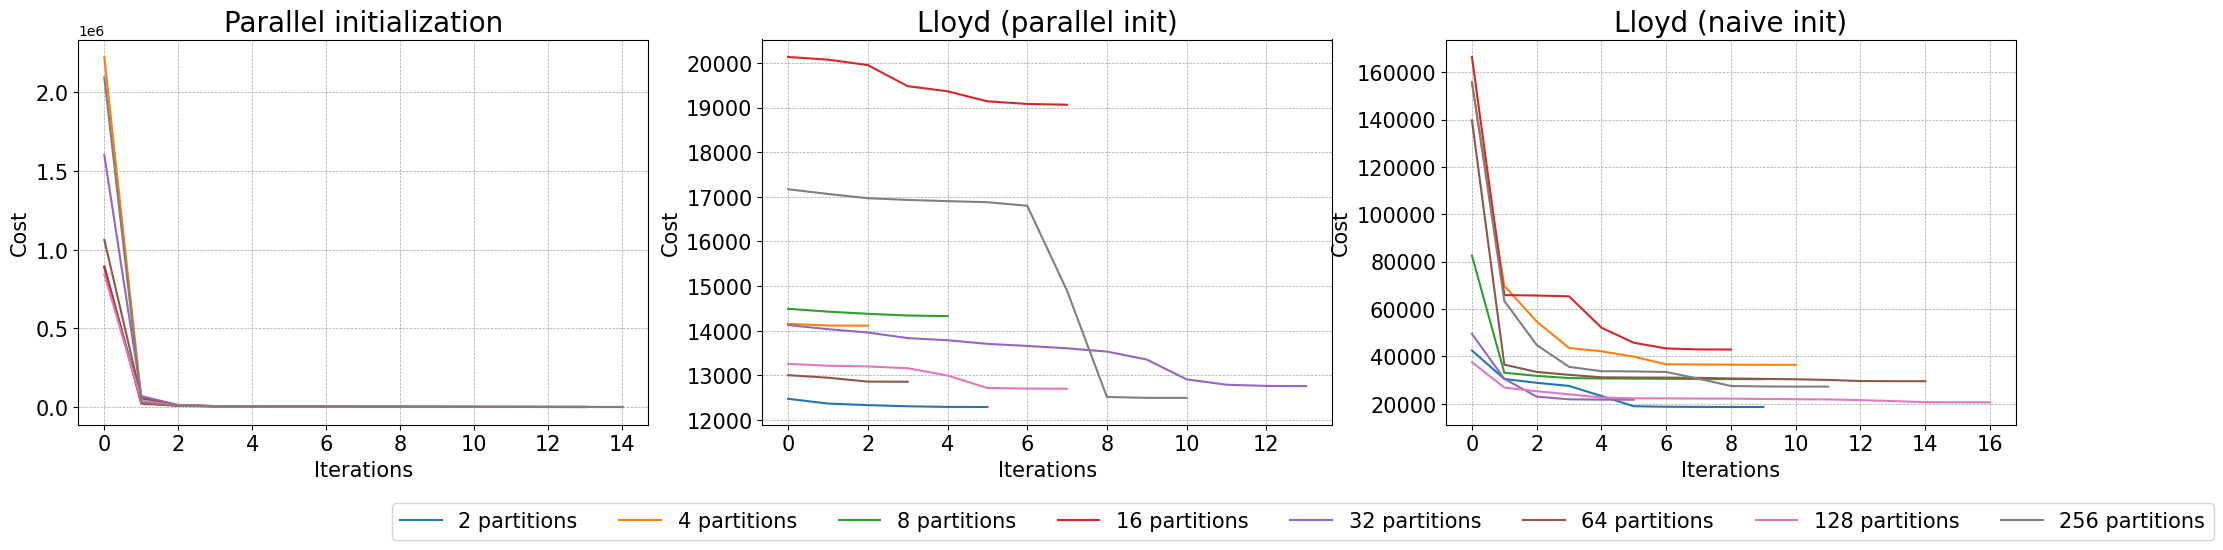

In [51]:
# Figure to compare the cost during different phases of the algorithm
fig, (axInit, ax0, ax1)=plt.subplots(ncols=3, nrows=1, sharey=False, figsize=(25, 5))
label_names = [str(int_partitions[i])+" partitions" for i in range(len(int_partitions))]
title_fontsize = 20
label_fontsize = 15

# Choose a sample
sample=0

# Unpack the data about the cost during the parallel initialization
initFold=totalLogP
NESTEDLIST=[[sample['totalLogParallelInit'][n_partition]['CostInit'] for n_partition in name_partitions] for sample in initFold]

# Plot the data
for i in range(len(name_partitions)):
    axInit.plot(NESTEDLIST[sample][i], label=label_names[i])
axInit.set_xlabel('Iterations', fontsize=label_fontsize)
axInit.set_ylabel('Cost', fontsize=label_fontsize)
axInit.set_title('Parallel initialization', fontsize=title_fontsize)
axInit.tick_params(axis='x', labelsize=label_fontsize)
axInit.tick_params(axis='y', labelsize=label_fontsize)
axInit.xaxis.set_major_locator(MaxNLocator(integer=True))
axInit.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

# Unpack the data about the cost during the Lloys iterations after parallel initialization
initFold=totalLogP
NESTEDLIST=[[sample['totalLogParallelKmeans'][n_partition]['CostsKmeans'] for n_partition in name_partitions] for sample in initFold]

# Plot the data
for i in range(len(name_partitions)):
    ax0.plot(NESTEDLIST[sample][i], label=label_names[i])
ax0.set_xlabel('Iterations', fontsize=label_fontsize)
ax0.set_ylabel('Cost', fontsize=label_fontsize)
ax0.set_title('Lloyd (parallel init)', fontsize=title_fontsize)
ax0.tick_params(axis='x', labelsize=label_fontsize)
ax0.tick_params(axis='y', labelsize=label_fontsize)
ax0.xaxis.set_major_locator(MaxNLocator(integer=True))
ax0.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')

# Unpack the data about the cost during the Lloyds iterations after random initialization
initFold=totalLogR
NESTEDLIST=[[sample['totalLogNaiveKmeans'][n_partition]['CostsKmeans'] for n_partition in name_partitions] for sample in initFold]

# Plot the data
for i in range(len(name_partitions)):
    ax1.plot(NESTEDLIST[sample][i], label=label_names[i])
ax1.set_xlabel('Iterations', fontsize=label_fontsize)
ax1.set_ylabel('Cost', fontsize=label_fontsize)
ax1.set_title('Lloyd (naive init)', fontsize=title_fontsize)
ax1.tick_params(axis='x', labelsize=label_fontsize)
ax1.tick_params(axis='y', labelsize=label_fontsize)
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.7, color='gray')
ax1.legend(loc=(-1.85, -0.3), fontsize=15, ncols=len(int_partitions))

In [ ]:
# Stop the context
sc.stop()